## A03 - Q02

## Preprocess CIFAR 10 dataset 

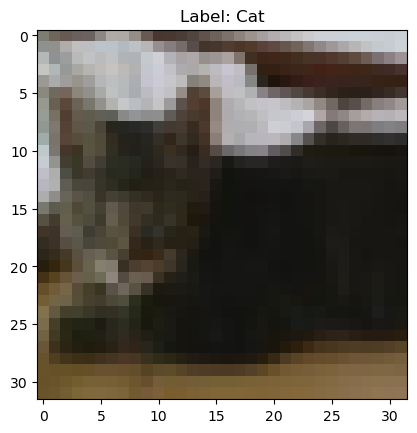

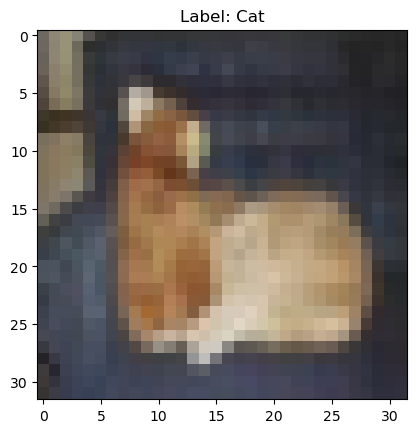

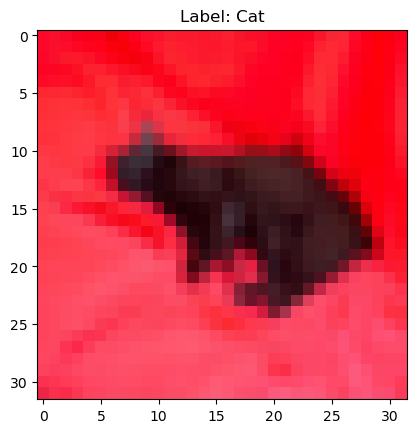

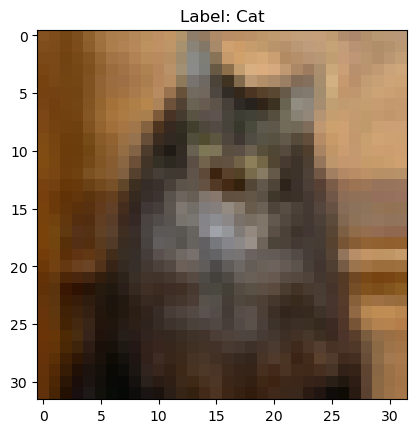

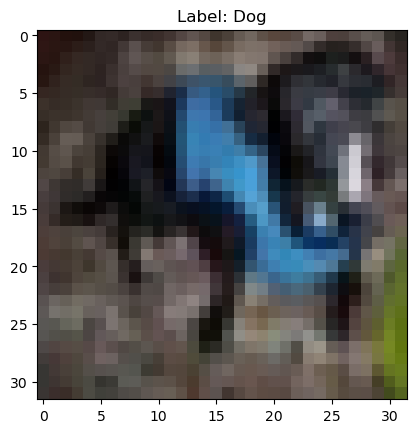

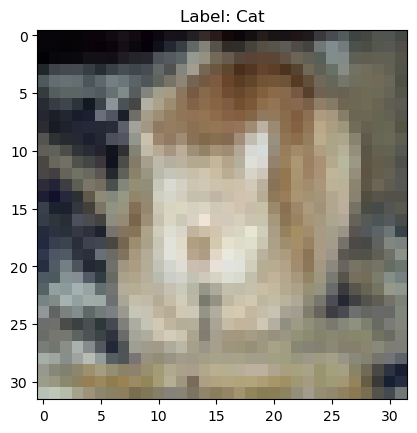

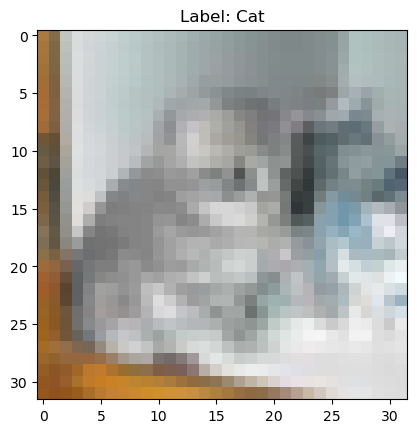

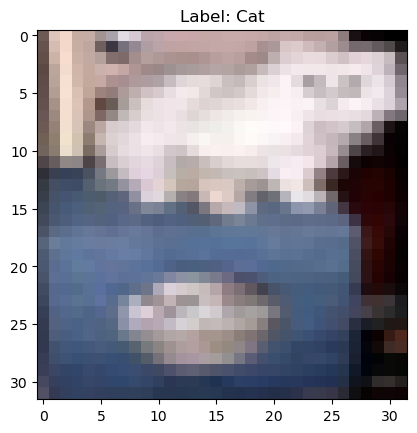

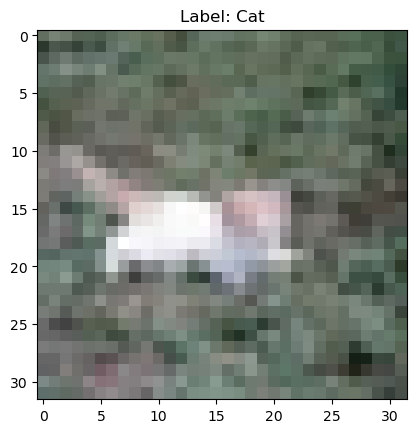

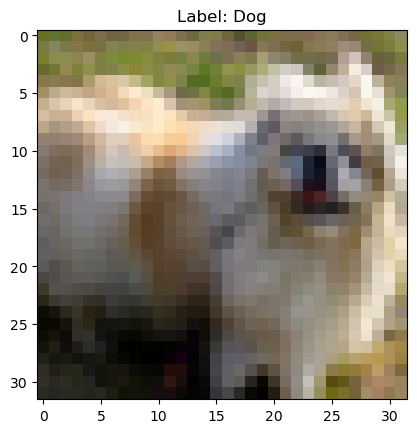

In [1]:
# hello 
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Define CIFAR-10 label indices (adjust if using CIFAR-100 and different labels)
CAT_LABEL = 3
DOG_LABEL = 5

# Function to load a CIFAR batch file
def load_cifar_batch(file_path):
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    return batch

# Function to extract cat and dog images from a batch
def get_cat_dog_images(batch):
    data = batch[b'data']
    labels = batch[b'labels']  # Use [b'fine_labels'] for CIFAR-100 if needed

    # Find indices of cat and dog images
    cat_dog_indices = [i for i, label in enumerate(labels) if label == CAT_LABEL or label == DOG_LABEL]

    # Extract images and labels for cats and dogs
    images = data[cat_dog_indices]
    labels = [labels[i] for i in cat_dog_indices]
    
    # Reshape images to 32x32x3
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    
    return images, labels

# Load a batch file and get cat and dog images
file_path = 'C:\\Users\\Zunaira\\Downloads\\Compressed\\cifar-10-python\\cifar-10-batches-py\\data_batch_1'  # Path to your CIFAR batch file
batch = load_cifar_batch(file_path)
cat_dog_images, cat_dog_labels = get_cat_dog_images(batch)

# Display a few cat and dog images
for i in range(10):
    plt.imshow(cat_dog_images[i])
    label = "Cat" if cat_dog_labels[i] == CAT_LABEL else "Dog"
    plt.title(f"Label: {label}")
    plt.show()


## Implementing Vit from Scratch 

170498071/170498071 [==============================] - 163s 1us/step


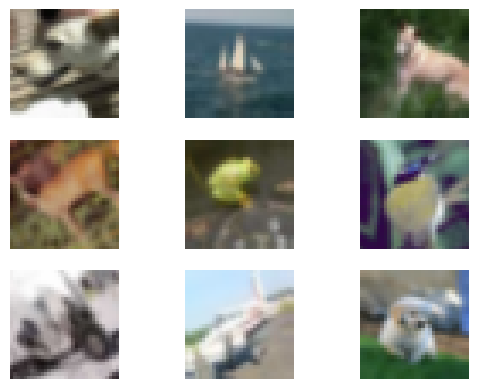

Data preprocessing completed!


In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Define data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Randomly flip images horizontally
    tf.keras.layers.RandomRotation(0.1),       # Randomly rotate images
    tf.keras.layers.RandomZoom(0.1),           # Randomly zoom in on images
    tf.keras.layers.RandomCrop(32, 32)         # Random crop to original size
])

# Create a data pipeline for the training set
train_dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(buffer_size=50000)                 # Shuffle the dataset
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)  # Apply augmentation
    .batch(64)                                  # Batch the data
    .prefetch(buffer_size=tf.data.AUTOTUNE)     # Prefetch for performance
)

# Create a data pipeline for the test set (without augmentation)
test_dataset = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(64)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Example: Preview augmented images
import matplotlib.pyplot as plt

for images, labels in train_dataset.take(1):
    for i in range(9):  # Display first 9 images in a 3x3 grid
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')
    plt.show()

print("Data preprocessing completed!")


## Implementation of Vit

In [3]:
import tensorflow as tf
from tensorflow.keras import layers

# Configuration Parameters
img_size = 32  # CIFAR-10 image size
patch_size = 4  # Size of each patch
num_patches = (img_size // patch_size) ** 2
embed_dim = 64  # Embedding size for each patch
num_heads = 4  # Number of attention heads
mlp_dim = 128  # Dimensionality of MLP in Transformer
num_layers = 6  # Number of Transformer blocks
num_classes = 10  # Number of output classes
dropout_rate = 0.1  # Dropout rate

# Helper Functions
def create_patches(images, patch_size):
    """Divides images into patches."""
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID"
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

class PatchEncoder(layers.Layer):
    """Encodes patches using a dense layer and adds positional encoding."""
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(embed_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

def mlp_block(x, hidden_units, dropout_rate):
    """Defines the MLP block."""
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def transformer_block(x, num_heads, mlp_dim, dropout_rate):
    """Defines a Transformer block."""
    # Multi-head Self Attention
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    # MLP
    mlp_output = mlp_block(x, hidden_units=[mlp_dim, x.shape[-1]], dropout_rate=dropout_rate)
    x = layers.Add()([x, mlp_output])
    x = layers.LayerNormalization()(x)
    return x

# Vision Transformer Model
def create_vit():
    inputs = layers.Input(shape=(img_size, img_size, 3))
    
    # Step 1: Divide the image into patches
    patches = create_patches(inputs, patch_size)
    
    # Step 2: Encode patches with positional encoding
    encoded_patches = PatchEncoder(num_patches=num_patches, embed_dim=embed_dim)(patches)
    
    # Step 3: Apply Transformer blocks
    x = encoded_patches
    for _ in range(num_layers):
        x = transformer_block(x, num_heads=num_heads, mlp_dim=mlp_dim, dropout_rate=dropout_rate)
    
    # Step 4: Classify the output
    representation = layers.LayerNormalization()(x[:, 0])  # Use the [CLS] token
    outputs = layers.Dense(num_classes, activation='softmax')(representation)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Compile and Train the Model
model = create_vit()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Prepare CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
782/782 [==============================] - 600s 759ms/step - loss: 1.7248 - accuracy: 0.3619 - val_loss: 1.4244 - val_accuracy: 0.4686
Epoch 2/10
782/782 [==============================] - 537s 687ms/step - loss: 1.3403 - accuracy: 0.5149 - val_loss: 1.2398 - val_accuracy: 0.5505
Epoch 3/10
782/782 [==============================] - 532s 680ms/step - loss: 1.1987 - accuracy: 0.5671 - val_loss: 1.2450 - val_accuracy: 0.5531
Epoch 4/10
782/782 [==============================] - 511s 654ms/step - loss: 1.1150 - accuracy: 0.6001 - val_loss: 1.1382 - val_accuracy: 0.5895
Epoch 5/10
782/782 [==============================] - 506s 647ms/step - loss: 1.0492 - accuracy: 0.6248 - val_loss: 1.0973 - val_accuracy: 0.6088
Epoch 6/10
782/782 [==============================] - 502s 642ms/step - loss: 0.9910 - accuracy: 0.6482 - val_loss: 1.0611 - val_accuracy: 0.6182
Epoch 7/10
782/782 [==============================] - 503s 643ms/step - loss: 0.9443 - accuracy: 0.6646 - val_loss: 1.0318 -

## Save Model

In [4]:
# Save the model in SavedModel format
model.save('vit_model_saved')


INFO:tensorflow:Assets written to: vit_model_saved\assets


INFO:tensorflow:Assets written to: vit_model_saved\assets


## Load Model

In [ ]:
# Load the SavedModel format
loaded_model_saved = tf.keras.models.load_model('vit_model_saved')

# Load the HDF5 format
loaded_model_h5 = tf.keras.models.load_model('vit_model.h5')


## Evaluate Model 

313/313 [==============================] - 37s 114ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.71      0.65      0.68      1000
  automobile       0.82      0.70      0.76      1000
        bird       0.61      0.52      0.56      1000
         cat       0.48      0.50      0.49      1000
        deer       0.68      0.47      0.55      1000
         dog       0.56      0.60      0.58      1000
        frog       0.75      0.75      0.75      1000
       horse       0.58      0.80      0.67      1000
        ship       0.72      0.82      0.77      1000
       truck       0.71      0.78      0.74      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.65     10000
weighted avg       0.66      0.66      0.65     10000



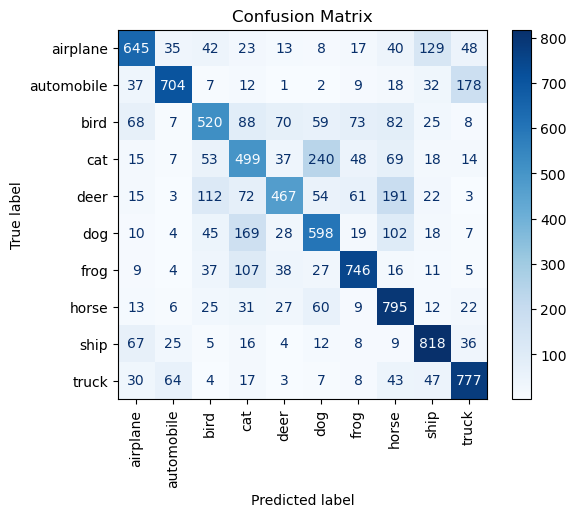

In [7]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(x_test)  # Predict probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class predictions

# Flatten the true labels
y_test_flat = y_test.flatten()

# Calculate metrics
print("Classification Report:")
print(classification_report(y_test_flat, y_pred_classes, target_names=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
]))

# Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
])
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


## CNN + MLP 

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Configuration Parameters
config = {
    "img_size": 32,        # CIFAR-10 image size
    "patch_size": 4,       # Patch size for CNN
    "num_classes": 10,     # Number of classes in CIFAR-10
    "batch_size": 128,     # Batch size
    "epochs": 50,          # Number of epochs
    "learning_rate": 1e-4  # Learning rate
}

# Define the Hybrid CNN + MLP Model
def create_cnn_mlp_hybrid(config):
    inputs = layers.Input(shape=(config["img_size"], config["img_size"], 3))

    # Step 1: Convolutional Layer for Patch Learning
    # We will simulate the patching process using convolutional layers.
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Step 2: Flatten the output for MLP
    x = layers.Flatten()(x)

    # Step 3: MLP Classification Layer
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)  # Dropout for regularization
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(config["num_classes"], activation="softmax")(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Compile the Model
cnn_mlp_model = create_cnn_mlp_hybrid(config)
cnn_mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config["learning_rate"]),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Prepare CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(50000).batch(config["batch_size"]).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(config["batch_size"]).prefetch(tf.data.AUTOTUNE)

# Train the Model
history = cnn_mlp_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=config["epochs"]
)

# Save the trained hybrid model
cnn_mlp_model.save('cnn_mlp_hybrid_model')


Epoch 1/50
391/391 [==============================] - 57s 143ms/step - loss: 2.0790 - accuracy: 0.2193 - val_loss: 1.7713 - val_accuracy: 0.3815
Epoch 2/50
391/391 [==============================] - 58s 148ms/step - loss: 1.7600 - accuracy: 0.3470 - val_loss: 1.5598 - val_accuracy: 0.4423
Epoch 3/50
391/391 [==============================] - 59s 150ms/step - loss: 1.6306 - accuracy: 0.3996 - val_loss: 1.4374 - val_accuracy: 0.4868
Epoch 4/50
391/391 [==============================] - 58s 148ms/step - loss: 1.5421 - accuracy: 0.4366 - val_loss: 1.3769 - val_accuracy: 0.5112
Epoch 5/50
391/391 [==============================] - 58s 148ms/step - loss: 1.4670 - accuracy: 0.4663 - val_loss: 1.3073 - val_accuracy: 0.5373
Epoch 6/50
391/391 [==============================] - 58s 149ms/step - loss: 1.4030 - accuracy: 0.4941 - val_loss: 1.2503 - val_accuracy: 0.5588
Epoch 7/50
391/391 [==============================] - 58s 148ms/step - loss: 1.3513 - accuracy: 0.5127 - val_loss: 1.1941 - val_ac

INFO:tensorflow:Assets written to: cnn_mlp_hybrid_model\assets


INFO:tensorflow:Assets written to: cnn_mlp_hybrid_model\assets


## Implement a ResNet model for Image Classification

313/313 [==============================] - 5s 17ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.79      0.78      0.79      1000
  automobile       0.84      0.85      0.85      1000
        bird       0.74      0.55      0.63      1000
         cat       0.55      0.53      0.54      1000
        deer       0.61      0.77      0.68      1000
         dog       0.60      0.68      0.64      1000
        frog       0.79      0.82      0.80      1000
       horse       0.77      0.80      0.78      1000
        ship       0.88      0.82      0.85      1000
       truck       0.87      0.78      0.82      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



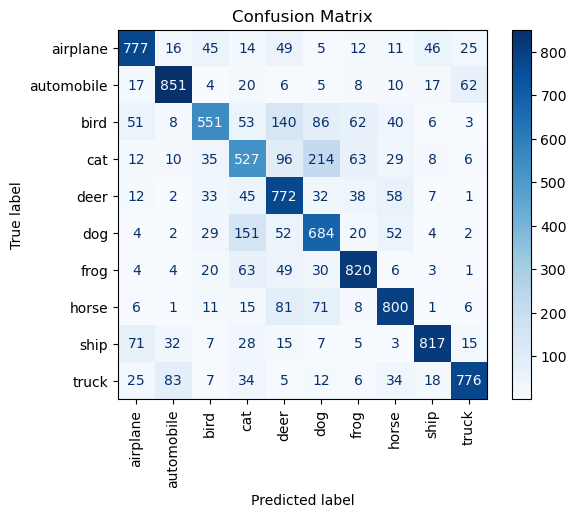

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict on test data
y_pred = cnn_mlp_model.predict(x_test)  # Predict probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class predictions

# Flatten the true labels
y_test_flat = y_test.flatten()

# Classification Report
print("Classification Report:")
print(classification_report(y_test_flat, y_pred_classes, target_names=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
]))

# Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
])
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


## Compare Perfformance of models 

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize the images

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Load the pretrained ResNet50 model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',  # Pretrained on ImageNet
    include_top=False,   # Exclude the top classification layer
    input_shape=(32, 32, 3)  # CIFAR-10 image size
)

# Freeze the base model's layers
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,  # Pretrained ResNet base
    layers.GlobalAveragePooling2D(),  # Add global average pooling
    layers.Dense(256, activation='relu'),  # Custom dense layer
    layers.Dropout(0.5),  # Regularization
    layers.Dense(128, activation='relu'),  # Additional dense layer
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=128,
    epochs=10  # Short training time for demonstration; adjust as needed
)

# Save the trained model
model.save('resnet_cifar10_transfer_learning.h5')


94765736/94765736 [==============================] - 26s 0us/step
Epoch 1/10
391/391 [==============================] - 104s 259ms/step - loss: 2.3255 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.0999
Epoch 2/10
391/391 [==============================] - 101s 258ms/step - loss: 2.3028 - accuracy: 0.0949 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/10
391/391 [==============================] - 106s 271ms/step - loss: 2.3028 - accuracy: 0.0978 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/10
391/391 [==============================] - 108s 276ms/step - loss: 2.3027 - accuracy: 0.0964 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/10
391/391 [==============================] - 109s 280ms/step - loss: 2.3027 - accuracy: 0.0967 - val_loss: 2.3026 - val_accuracy: 0.1001
Epoch 6/10
391/391 [==============================] - 110s 280ms/step - loss: 2.3027 - accuracy: 0.0984 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/10
391/391 [==============================] - 109s

In [11]:
# Unfreeze the top layers of the base model for fine-tuning
base_model.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_finetune = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=128,
    epochs=5  # Fine-tuning with fewer epochs
)


Epoch 1/5
391/391 [==============================] - 1912s 5s/step - loss: 3.0823 - accuracy: 0.1092 - val_loss: 103.3532 - val_accuracy: 0.0980
Epoch 2/5
391/391 [==============================] - 1903s 5s/step - loss: 2.3783 - accuracy: 0.1328 - val_loss: 2.8797 - val_accuracy: 0.1617
Epoch 3/5
391/391 [==============================] - 1905s 5s/step - loss: 2.2723 - accuracy: 0.1551 - val_loss: 2.2423 - val_accuracy: 0.2529
Epoch 4/5
391/391 [==============================] - 1909s 5s/step - loss: 2.1836 - accuracy: 0.1962 - val_loss: 2.1191 - val_accuracy: 0.3098
Epoch 5/5
391/391 [==============================] - 1916s 5s/step - loss: 2.0795 - accuracy: 0.2456 - val_loss: 1.9694 - val_accuracy: 0.3842


313/313 [==============================] - 45s 138ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.43      0.37      0.40      1000
  automobile       0.38      0.39      0.38      1000
        bird       0.33      0.08      0.12      1000
         cat       0.30      0.23      0.26      1000
        deer       0.42      0.26      0.32      1000
         dog       0.31      0.36      0.33      1000
        frog       0.38      0.63      0.48      1000
       horse       0.44      0.36      0.39      1000
        ship       0.44      0.75      0.56      1000
       truck       0.36      0.41      0.38      1000

    accuracy                           0.38     10000
   macro avg       0.38      0.38      0.36     10000
weighted avg       0.38      0.38      0.36     10000



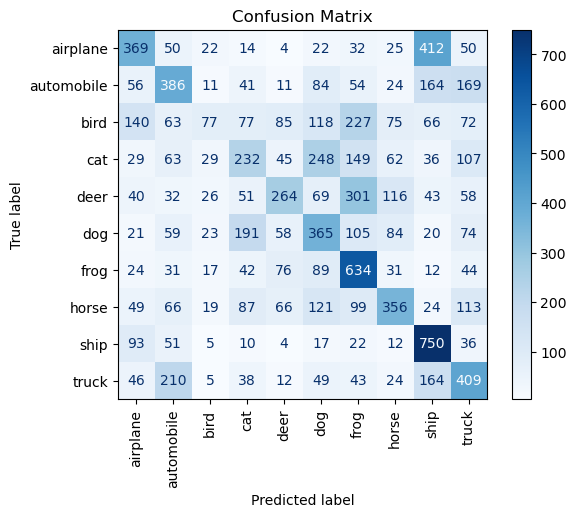

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
]))

# Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
])
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
def visualize_results(model, model_name, x_test, y_test, num_images=10):
    predictions = model.predict(x_test)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = y_test.flatten()

    # Select indices of correct and incorrect predictions
    correct_indices = np.where(predicted_labels == true_labels)[0][:num_images]
    incorrect_indices = np.where(predicted_labels != true_labels)[0][:num_images]

    # Plot correct predictions
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(correct_indices):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(x_test[idx])
        plt.title(f"True: {true_labels[idx]}, Pred: {predicted_labels[idx]}")
        plt.axis('off')
    plt.suptitle(f"{model_name} - Correct Predictions", fontsize=16)
    plt.show()

    # Plot incorrect predictions
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(incorrect_indices):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(x_test[idx])
        plt.title(f"True: {true_labels[idx]}, Pred: {predicted_labels[idx]}")
        plt.axis('off')
    plt.suptitle(f"{model_name} - Incorrect Predictions", fontsize=16)
    plt.show()

# Visualize results for each model
visualize_results(model, "ResNet", x_test, y_test)
visualize_results(vit_model, "Vision Transformer", x_test, y_test)
visualize_results(hybrid_model, "Hybrid CNN+MLP", x_test, y_test)


NameError: name 'resnet_model' is not defined